In [134]:
import pandas as pd
import requests
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

In [94]:
offdata = requests.get('http://rdatasciencecases.org/Data/offline.final.trace.txt')
ondata = requests.get('http://rdatasciencecases.org/Data/online.final.trace.txt')

In [99]:
def eda_trace(data):
    
    data = data.text.split('\n')
    data = list(filter(lambda m: (not m.startswith('#')) and (not len(m) == 0), data))
    data = [row.split(';') for row in data]
    
    mac_keep = eda_MAC(data)
    print(mac_keep)
    mac = [val for (val, key) in mac_keep]
    # Keep only the top7 mac address and remove the rest.
    count=0
    for row in data:
        for macId in row[4:]:
            macs = macId.split("=")[0]
            if macs in mac:
                continue
            else:
                data[count].remove(macId)
        count += 1
    
    df = pd.DataFrame(data)
    
    #cols = [m.split("=")[0] for m in df.iloc[1][:4].values]
    mac_names = ['MAC_'+str(m) for m in range(len(df.iloc[1][4:].values))]
    cols = ["TimeStamp", "MACofScanDevice", "RealPosition","Orientation"]
    col_names = cols + mac_names
    
    cols = dict(list(zip(df.columns.values, col_names)))
    df.rename(columns=cols, inplace=True)
    
    df["TimeStamp"] = df["TimeStamp"].map(lambda x: x.lstrip('t='))
    df["MACofScanDevice"] = df["MACofScanDevice"].map(lambda x: x.lstrip('id='))
    df["RealPosition"] = df["RealPosition"].map(lambda x: x.lstrip('pos='))
    df["Orientation"] = df["Orientation"].map(lambda x: x.lstrip('degree='))
    
    df['Orientation'] = pd.to_numeric(df.Orientation, errors='coerce', downcast='float')
    df['TimeStamp'] = df['TimeStamp'].astype(int)
    df["TimeStamp"] = df["TimeStamp"]/1000
    df['TimeStamp'] = df['TimeStamp'].astype('datetime64[ns]')
    
    # Create list of position x, y & z.
    p = {}
    for i, j in enumerate(df.RealPosition.values):
        if j != None:
            temp = j.split(",")
            p[i] = [float(y) for y in temp]
        else:
            p[i] = None

    pos = pd.Series(p)
    df['RealPosition'] = pos
    
    # Create MAC Dictionary with Signal, Channel and Type.
    for col in df.iloc[:,4:].columns:
        m = {}
        colString = '{}'.format(col)
        for i, j in enumerate(df[colString].values):
            if j != None:
                temp = j.split("=")
                macId = temp[0]
                coords = [int(y) for y in temp[1].split(",")]
                # we drop all records for adhoc measurements and remove the type variable from our data frame
                # Refer Data Science in R by Deborah Nolan & Duncan Temple Lang
                if (coords[-1] == 3):
                    m[i] = {macId: [coords[:2], coords[-1]]}
                else:
                    m[i] = None
            else:
                m[i] = None
    
        df[colString] = pd.Series(m)
    
    df["MACofScanDevice"] = df["MACofScanDevice"].astype('category')
    # There is only one hand-held device used to take the measurement, can be discarded from the dataframe
    pd.value_counts(df["MACofScanDevice"].values, sort=False)

    df = df.drop(['MACofScanDevice'], axis=1)
    
    df['Angle'] = df.apply (lambda row: label_angle(row), axis=1)
    
    # Angle z is zero since all the measurement are from ground
    for key, val in enumerate(df["RealPosition"]):
        del val[2]
        
    return data, df

In [100]:
def eda_MAC (data):
    macs = set(mac.split('=')[0].lower() for row in data for mac in row[4:])
    print('There are %d unique MACs in the dataset' % len(macs))
    mac_counts = []
    for mac in macs:
        count = 0
        for row in data:
            for macId in row[4:]:
                macId = macId.split("=")[0]
                if mac in macId:
                    count += 1
        mac_counts.append((mac, count))
    
    mac_counts = sorted(mac_counts, key=lambda x: x[1], reverse=True)
    mac_keep = mac_counts[:7]
    return mac_keep

There are 21 MAC address where as from the document there are only 6 access points. It could be due to the points are not part of the testing area.

There are potential signals recorded at 166 grid points, 8 orientations and 110 replications (166x8x110 = 146080). 

Clearly the last six MAC addresses are not near the testing area or were only working/active for a short time during the measurement process because their counts are very low. 

We have decided to keep the top 7 devices. Note: Mac address with 103887 recording starts with 02. Decided not to include for our analysis based on the findings from text book

In [101]:
def label_angle (row):
    if row['Orientation'] <= 45 :
        return 45
    if row['Orientation'] >45 and row['Orientation'] <=90 :
        return 90
    if row['Orientation'] >90 and row['Orientation'] <=135 :
        return 135
    if row['Orientation'] >135 and row['Orientation'] <=180 :
        return 180
    if row['Orientation'] >180 and row['Orientation'] <=225 :
        return 225
    if row['Orientation'] >225 and row['Orientation'] <=270 :
        return 270
    if row['Orientation'] >270 and row['Orientation'] <=315 :
        return 315
    if row['Orientation'] >315 :
        return 360
    return 45

In [102]:
offdata, offline = eda_trace(offdata)
ondata, online = eda_trace(ondata)

There are 21 unique MACs in the dataset
There are 14 unique MACs in the dataset


In [103]:
offline.tail()

,TimeStamp,RealPosition,Orientation,MAC_0,MAC_1,MAC_2,MAC_3,MAC_4,MAC_5,MAC_6,MAC_7,MAC_8,MAC_9,MAC_10,MAC_11,MAC_12,MAC_13,Angle
146075,1970-01-01 00:00:01.141936869,"[20.0, 8.0, 0.0]",315.700012,"{'00:0f:a3:39:e1:c0': [[-51, 2462000000], 3]}","{'00:14:bf:b1:97:8d': [[-56, 2442000000], 3]}","{'00:14:bf:b1:97:8a': [[-60, 2437000000], 3]}","{'00:14:bf:b1:97:90': [[-69, 2427000000], 3]}","{'00:0f:a3:39:dd:cd': [[-76, 2412000000], 3]}",None,None,None,None,None,None,None,None,None,360
146076,1970-01-01 00:00:01.141936869,"[20.0, 8.0, 0.0]",315.700012,"{'00:0f:a3:39:e1:c0': [[-53, 2462000000], 3]}","{'00:14:bf:3b:c7:c6': [[-52, 2432000000], 3]}","{'00:14:bf:b1:97:8d': [[-62, 2442000000], 3]}","{'00:14:bf:b1:97:81': [[-58, 2422000000], 3]}","{'00:14:bf:b1:97:8a': [[-61, 2437000000], 3]}","{'00:0f:a3:39:dd:cd': [[-77, 2412000000], 3]}",None,None,None,None,None,None,None,None,360
146077,1970-01-01 00:00:01.141936869,"[20.0, 8.0, 0.0]",315.700012,"{'00:0f:a3:39:e1:c0': [[-54, 2462000000], 3]}","{'00:14:bf:3b:c7:c6': [[-58, 2432000000], 3]}","{'00:14:bf:b1:97:8d': [[-56, 2442000000], 3]}","{'00:14:bf:b1:97:8a': [[-60, 2437000000], 3]}","{'00:14:bf:b1:97:90': [[-69, 2427000000], 3]}","{'00:0f:a3:39:dd:cd': [[-77, 2412000000], 3]}","{'00:14:bf:b1:97:81': [[-62, 2422000000], 3]}",None,None,None,None,None,None,None,360
146078,1970-01-01 00:00:01.141936870,"[20.0, 8.0, 0.0]",315.700012,"{'00:14:bf:3b:c7:c6': [[-51, 2432000000], 3]}","{'00:0f:a3:39:e1:c0': [[-53, 2462000000], 3]}","{'00:14:bf:b1:97:8a': [[-61, 2437000000], 3]}","{'00:14:bf:b1:97:81': [[-60, 2422000000], 3]}","{'00:14:bf:b1:97:8d': [[-62, 2442000000], 3]}","{'00:0f:a3:39:dd:cd': [[-77, 2412000000], 3]}",None,None,None,None,None,None,None,None,360
146079,1970-01-01 00:00:01.141936870,"[20.0, 8.0, 0.0]",315.700012,"{'00:14:bf:3b:c7:c6': [[-56, 2432000000], 3]}","{'00:0f:a3:39:e1:c0': [[-53, 2462000000], 3]}","{'00:14:bf:b1:97:8d': [[-61, 2442000000], 3]}","{'00:14:bf:b1:97:8a': [[-60, 2437000000], 3]}","{'00:14:bf:b1:97:81': [[-60, 2422000000], 3]}","{'00:14:bf:b1:97:90': [[-68, 2427000000], 3]}","{'00:0f:a3:39:dd:cd': [[-76, 2412000000], 3]}",None,None,None,None,None,None,None,360


In [104]:
offline.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146080 entries, 0 to 146079
Data columns (total 18 columns):
TimeStamp       146080 non-null datetime64[ns]
RealPosition    146080 non-null object
Orientation     146080 non-null float32
MAC_0           146074 non-null object
MAC_1           146040 non-null object
MAC_2           145991 non-null object
MAC_3           145242 non-null object
MAC_4           139301 non-null object
MAC_5           115221 non-null object
MAC_6           63091 non-null object
MAC_7           11870 non-null object
MAC_8           1775 non-null object
MAC_9           291 non-null object
MAC_10          44 non-null object
MAC_11          7 non-null object
MAC_12          3 non-null object
MAC_13          1 non-null object
Angle           146080 non-null int64
dtypes: datetime64[ns](1), float32(1), int64(1), object(15)
memory usage: 19.5+ MB


In [105]:
online.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6592 entries, 0 to 6591
Data columns (total 19 columns):
TimeStamp       6592 non-null datetime64[ns]
RealPosition    6592 non-null object
Orientation     6592 non-null float32
MAC_0           6592 non-null object
MAC_1           6571 non-null object
MAC_2           6570 non-null object
MAC_3           6530 non-null object
MAC_4           6266 non-null object
MAC_5           5163 non-null object
MAC_6           2897 non-null object
MAC_7           676 non-null object
MAC_8           92 non-null object
MAC_9           13 non-null object
MAC_10          2 non-null object
MAC_11          1 non-null object
MAC_12          1 non-null object
MAC_13          1 non-null object
MAC_14          1 non-null object
Angle           6592 non-null int64
dtypes: datetime64[ns](1), float32(1), int64(1), object(16)
memory usage: 952.8+ KB


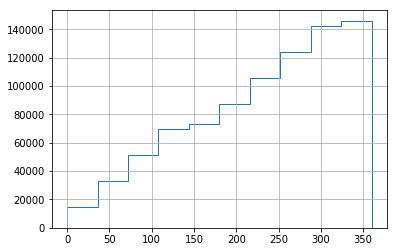

In [106]:
offline.Orientation.hist(cumulative=True, histtype='step', bins=10)

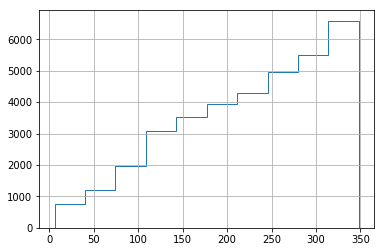

In [107]:
online.Orientation.hist(cumulative=True, histtype='step', bins=10)

In [108]:
pd.value_counts(offline["Angle"].values, sort=False)

135    19833
270    16540
45     20101
180    16745
315    18871
90     17794
225    19849
360    16347
dtype: int64

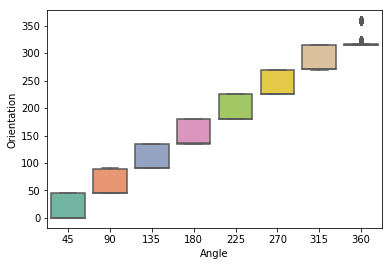

In [109]:
ax = sns.boxplot(x="Angle", y="Orientation", data=offline, palette="Set2")

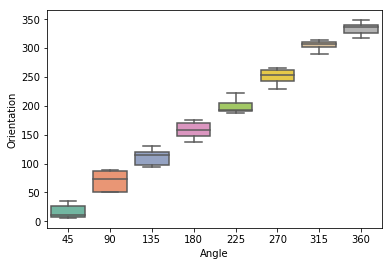

In [110]:
ax = sns.boxplot(x="Angle", y="Orientation", data=online, palette="Set2")

In [112]:
macs = set(mac.split('=')[0].lower() for row in offdata for mac in row[4:])
print('There are %d unique MACs in the dataset' % len(macs))

There are 7 unique MACs in the dataset


In [113]:
mac_keep = eda_MAC(offdata)

There are 7 unique MACs in the dataset


In [114]:
mac = [val for (val, key) in mac_keep]

In [115]:
mac

['00:0f:a3:39:e1:c0',
 '00:0f:a3:39:dd:cd',
 '00:14:bf:b1:97:8a',
 '00:14:bf:3b:c7:c6',
 '00:14:bf:b1:97:90',
 '00:14:bf:b1:97:8d',
 '00:14:bf:b1:97:81']

In [156]:
#offline.RealPosition.plot(kind='scatter')
offline['RealPosition'].str[1]
#for key, val in enumerate(offline["RealPosition"]):
#     plt.plot(val[0], val[1])

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
5         0.0
6         0.0
7         0.0
8         0.0
9         0.0
10        0.0
11        0.0
12        0.0
13        0.0
14        0.0
15        0.0
16        0.0
17        0.0
18        0.0
19        0.0
20        0.0
21        0.0
22        0.0
23        0.0
24        0.0
25        0.0
26        0.0
27        0.0
28        0.0
29        0.0
         ... 
146050    8.0
146051    8.0
146052    8.0
146053    8.0
146054    8.0
146055    8.0
146056    8.0
146057    8.0
146058    8.0
146059    8.0
146060    8.0
146061    8.0
146062    8.0
146063    8.0
146064    8.0
146065    8.0
146066    8.0
146067    8.0
146068    8.0
146069    8.0
146070    8.0
146071    8.0
146072    8.0
146073    8.0
146074    8.0
146075    8.0
146076    8.0
146077    8.0
146078    8.0
146079    8.0
Name: RealPosition, Length: 146080, dtype: float64